<a href="https://colab.research.google.com/github/kwanda2426/projects/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
import missingno as msno

#Model training
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


# **Importing Data**

In [ ]:
# Reading data
url = "https://raw.githubusercontent.com/kwanda2426/projects/main/sebokeng_data.xlsx"
df = pd.read_excel(url, engine='openpyxl')


In [ ]:
# Showing first 5 lines of data
df.head()


,sebSO2,sebNO2,sebO3,sebPM25,sebPM10
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


# **Data Preprocessing**

In this section, we transform raw data to well-formed data sets so that data analytics can be applied. Raw data is often incomplete and has inconsistent formatting. We do both data validation and data imputation.The goal of data imputation is to correct errors and input missing values. We were told of the time-series nature of our data set, but in this data the timestamp is missing, we therefore have to create that using the knowledge that the data is from January 2011 to February 2020.

The main goal is to ensure that the data in question is both complete and accurate.

In [ ]:
# changing column names
df['SO2'] = df['sebSO2']
df['NO2'] = df['sebNO2']
df['O3'] = df['sebO3']
df['PM25'] = df['sebPM25']
df['PM10'] = df['sebPM10']

In [ ]:
#Adding date column
new_date = pd.date_range(start='2011-01-01', end='2020-02-27', freq='D')
df['Date'] = new_date
#final dataframe
df_final = df[['Date','SO2', 'NO2', 'O3',
       'PM25', 'PM10']]

In [ ]:
df_final.head()

,Date,SO2,NO2,O3,PM25,PM10
0,2011-01-01,NaN,NaN,NaN,NaN,NaN
1,2011-01-02,NaN,NaN,NaN,NaN,NaN
2,2011-01-03,NaN,NaN,NaN,NaN,NaN
3,2011-01-04,NaN,NaN,NaN,NaN,NaN
4,2011-01-05,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_final.columns

Index(['Date', 'SO2', 'NO2', 'O3', 'PM25', 'PM10'], dtype='object')

In [ ]:
# Rows and Columns of data
print('Data has {} rows and {} Columns'.format(df_final.shape[0],df_final.shape[1]))
print('')
print('Data has the following columns:')
for i in df_final.columns:
  print(i)

Data has 3345 rows and 6 Columns

Data has the following columns:
Date
SO2
NO2
O3
PM25
PM10


### Data Type of Columns

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3345 entries, 0 to 3344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3345 non-null   datetime64[ns]
 1   SO2     1925 non-null   float64       
 2   NO2     2055 non-null   float64       
 3   O3      2371 non-null   float64       
 4   PM25    1853 non-null   float64       
 5   PM10    1827 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 156.9 KB


We can see that most of our columns have the same data type which is numeric and the Date in datetime.

In [ ]:
df_final[['SO2', 'NO2', 'O3', 'PM25', 'PM10']].describe()

,SO2,NO2,O3,PM25,PM10
count,1925.000000,2055.000000,2371.000000,1853.000000,1827.000000
mean,13.877048,25.350595,55.590021,31.673353,46.370742
std,11.669311,10.510577,24.103645,18.867618,24.009341
min,0.190387,0.000000,0.000000,3.634714,2.460333
25%,6.187676,18.360628,37.442500,19.661917,30.136500
50%,10.360277,23.416105,53.699667,27.742417,41.075083
75%,17.229557,30.367969,71.014333,38.294458,56.197313
max,115.727693,115.438737,199.584250,288.647042,194.949870


 We can see that non-null rows for each column is not the same as total rows, this means that our data has some missing entries.

From the summary statistics we can see that there's a gap between the min, mean and the maximum values for each column. This might be indicative of outliers. But this is not conclusive yet because we also have missing values in our dataset.

### Visualising Missing Data

<Figure size 800x400 with 0 Axes>

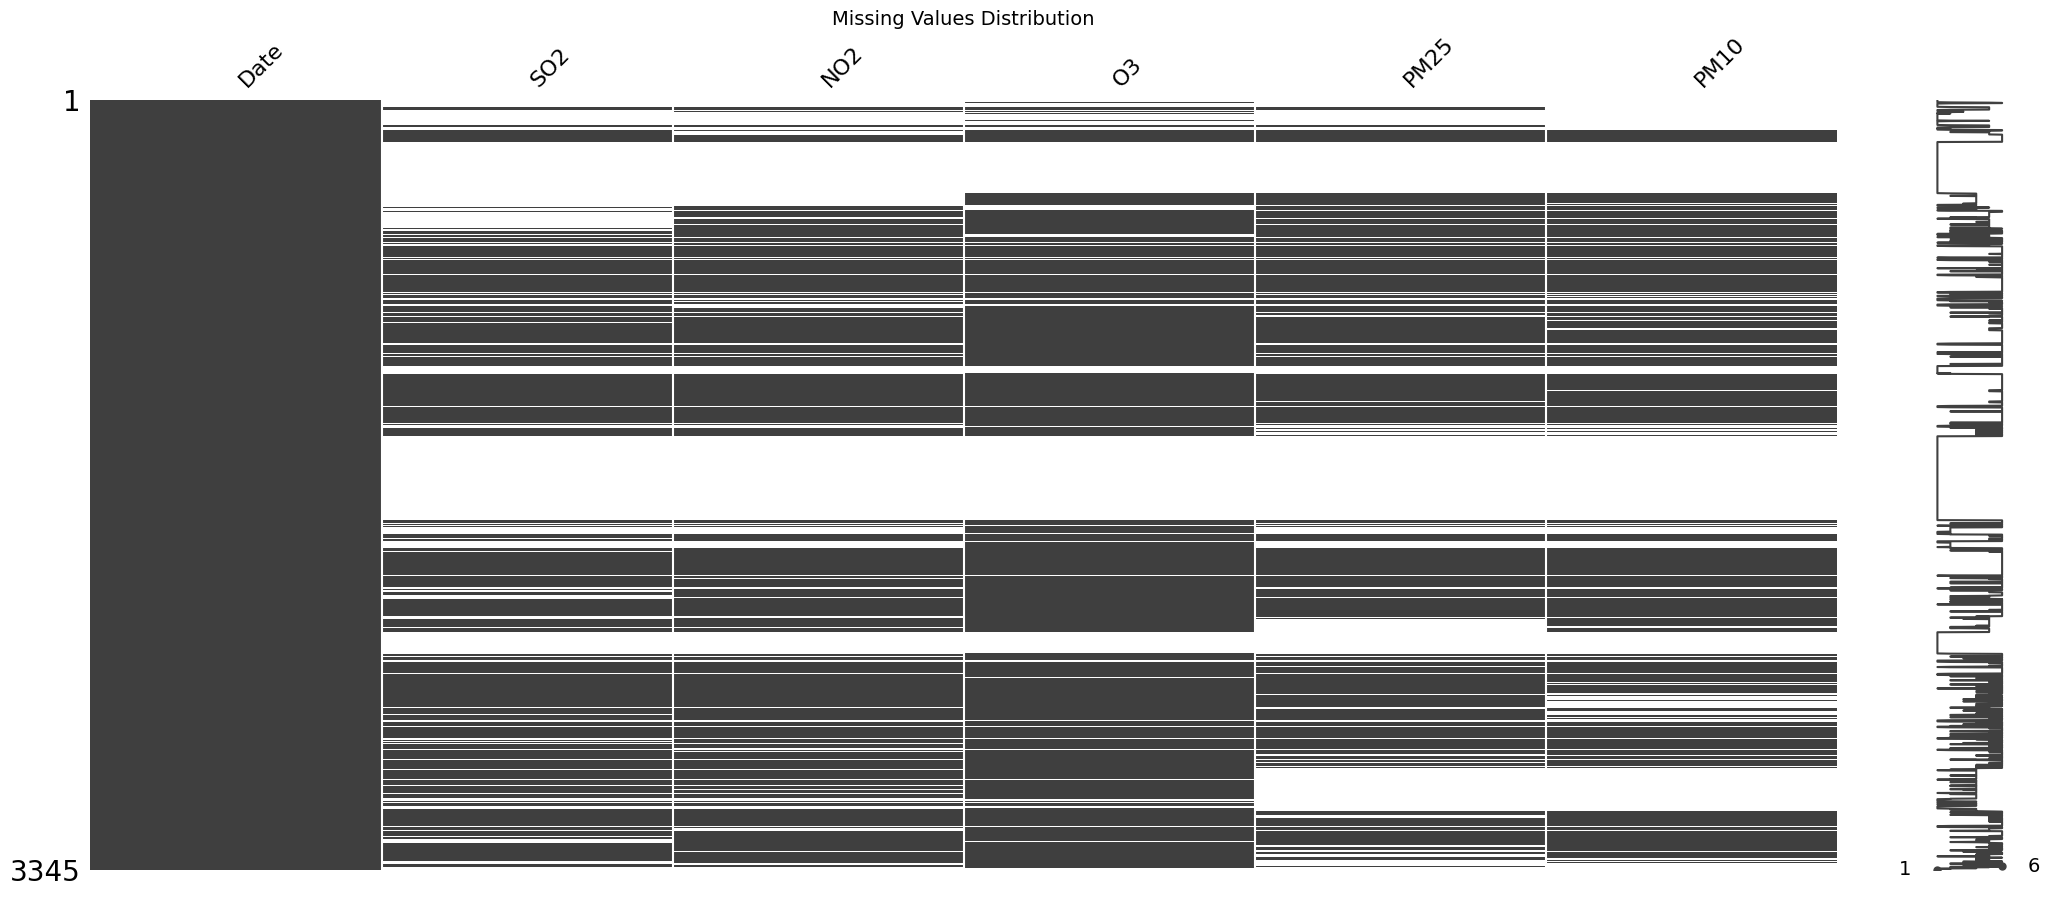

In [ ]:
# Missing entries distribution
plt.figure(figsize=(8, 4))  # Width x Height in inches
msno.matrix(df_final)
plt.title('Missing Values Distribution', fontsize = 14, loc ='center')
plt.tight_layout()
plt.show()

We can see that the didtribution of null/missing values in our data is close to being similar across these variables. This means that these variables might be correlated in their missingness.

<Figure size 800x400 with 0 Axes>

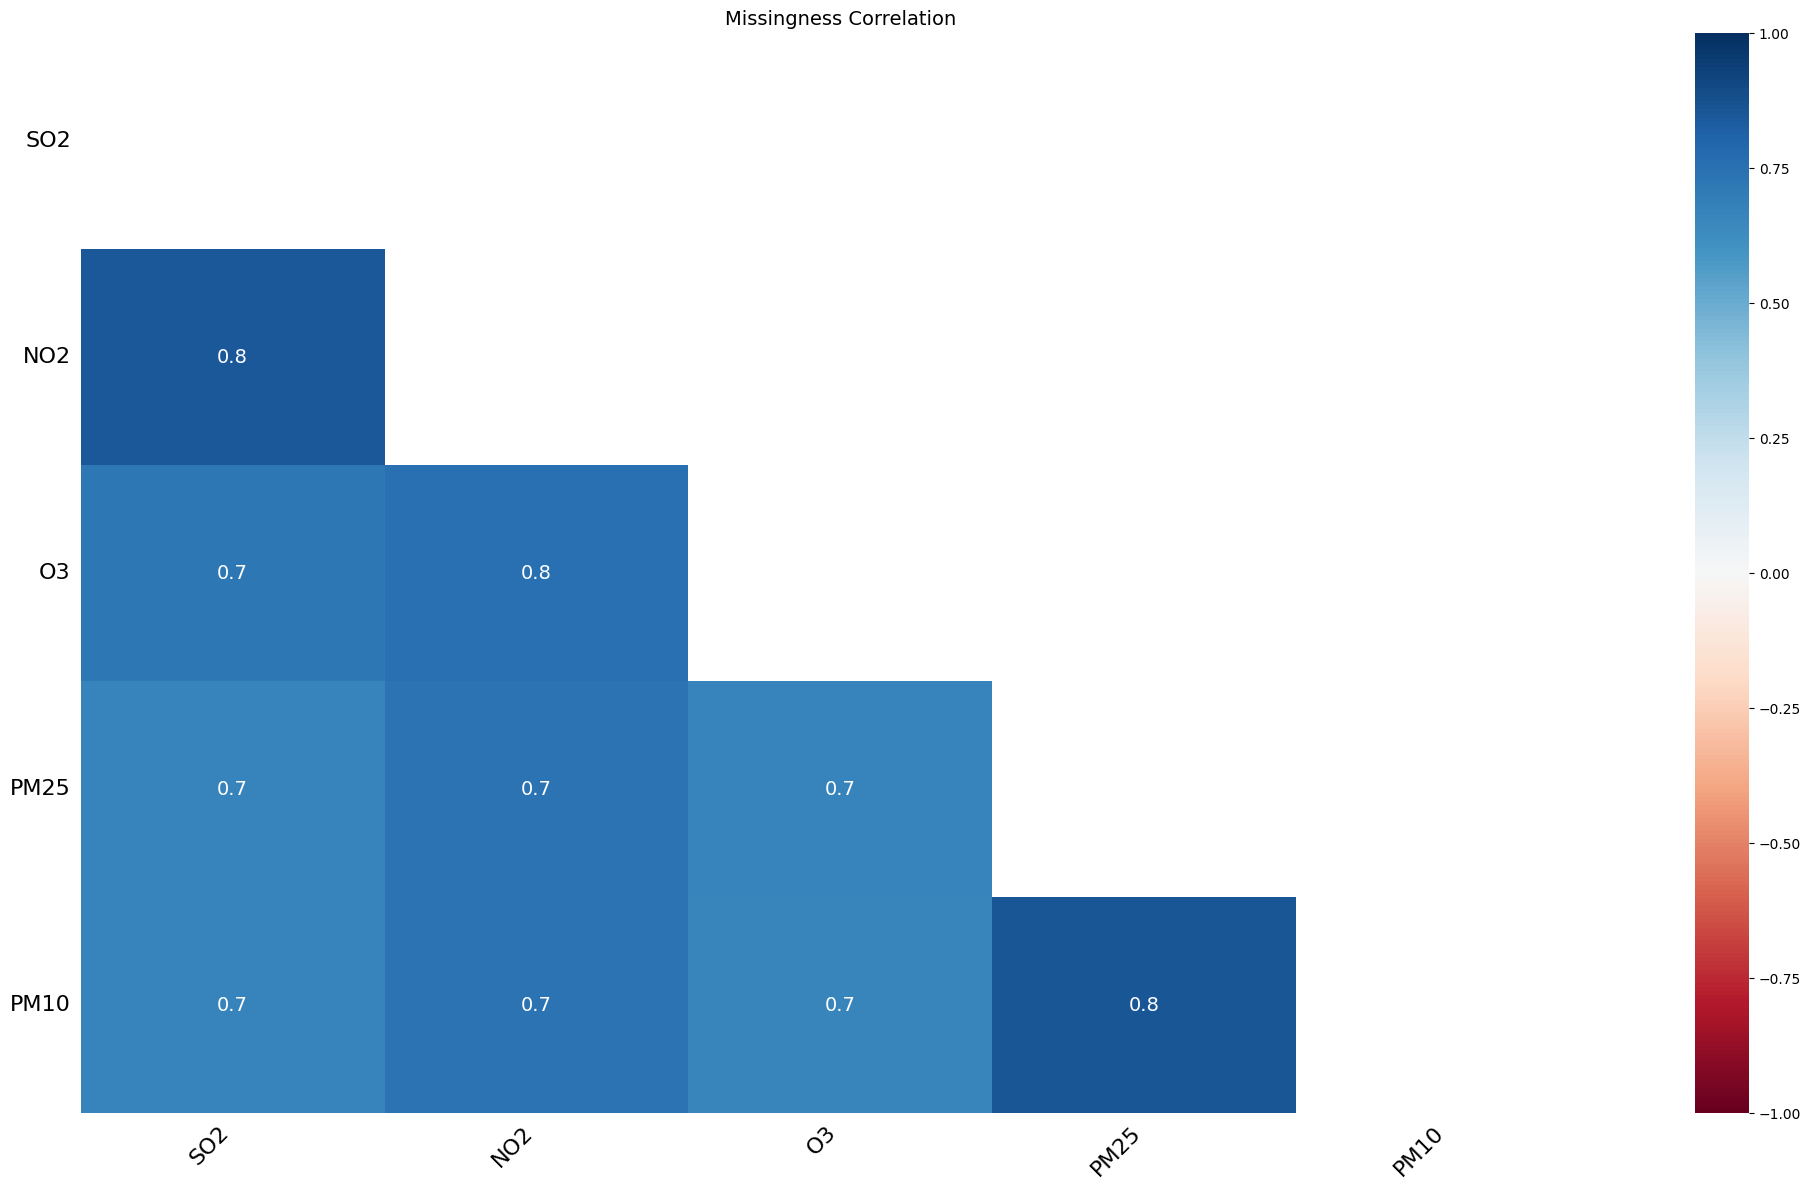

In [ ]:
# Missing entries distribution
plt.figure(figsize=(8, 4))
msno.heatmap(df_final[['SO2', 'NO2', 'O3', 'PM25', 'PM10']])
plt.title('Missingness Correlation', fontsize = 14, loc='center')
plt.tight_layout()
plt.show()

**Note:**+1 *means a strong correlation*.

There is no correlation that is less than 0.5.We can see that this missingness is highly and positively correlated, multivariate imputation is more appropriate.

In [ ]:
# Quantifying missing entries
cols = df_final.columns
rows = [int(df_final.isnull().sum()[i]) for i in range(0,len(df_final.columns))]
perc = [str(round(100*int(df_final.isnull().sum()[i])/df_final.shape[0],2))+'%' for i in range(0,len(df_final.columns))]


final_list = list(zip(cols,rows,perc))

# Create DataFrame from the zipped list with column names
missing_entries = pd.DataFrame(final_list, columns=['Column Name', 'Number of missing entries','% missing entries'])
missing_entries

,Column Name,Number of missing entries,% missing entries
0,Date,0,0.0%
1,SO2,1420,42.45%
2,NO2,1290,38.57%
3,O3,974,29.12%
4,PM25,1492,44.6%
5,PM10,1518,45.38%


We can see that our data is multivariate and all numeric columns have missing entries  greater than 20% and we cannot drop them, otherwise we will have no data. Hence to avoid risk of bias, consider advanced imputation.

### Data Visualisation

In [ ]:
df_1 = df_final.copy()
df_1.columns

Index(['Date', 'SO2', 'NO2', 'O3', 'PM25', 'PM10'], dtype='object')

In [ ]:
df_1['date'] = pd.to_datetime(df_1['Date'])
df_1 = [['date','SO2', 'NO2', 'O3', 'PM25', 'PM10']]
df_1.set_index('date', inplace=True)


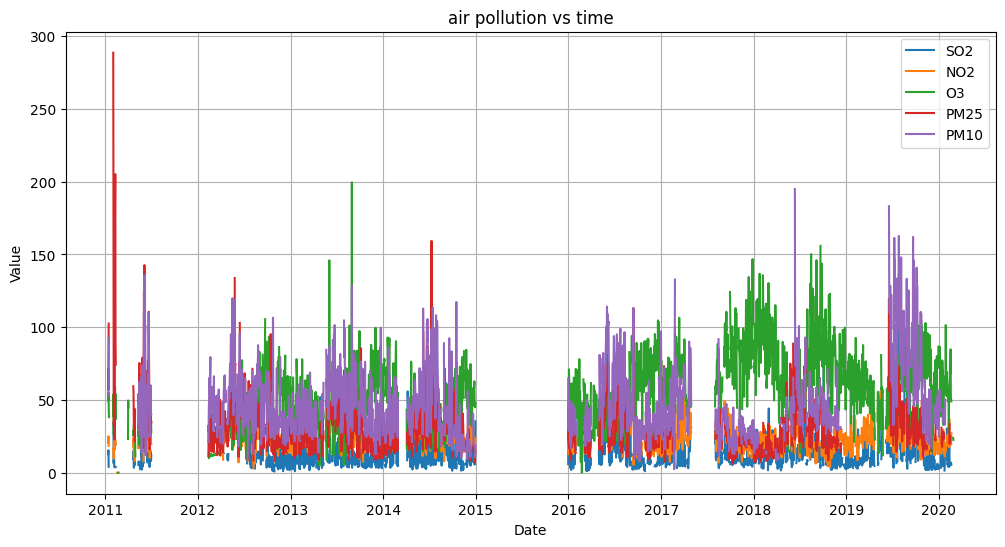

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
for col in df_1.columns:
    plt.plot(df_1.index, df_1[col], label=col)

plt.title("air pollution vs time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

We can see that there's definitely missing data between 2011 to 2012.The whole data between 2015 and 2016 is also missing.Finally between 2017 and 2018. This data is missing for all variables.

We can see that SO2 is lowest and O3 is the hightest of these 5. We will visualise these 2 variables individually.

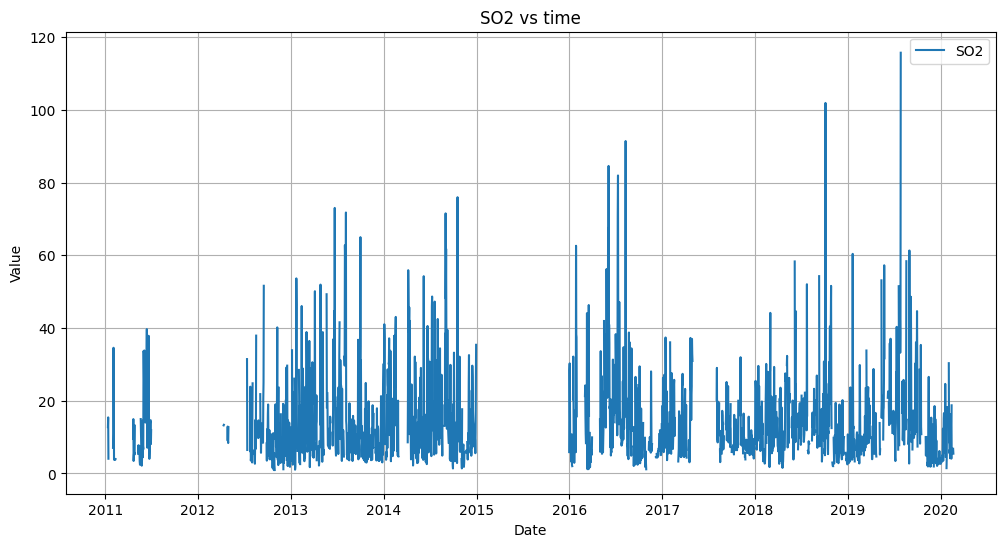

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
col = 'SO2'
plt.plot(df_1.index, df_1[col], label=col)

plt.title("SO2 vs time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

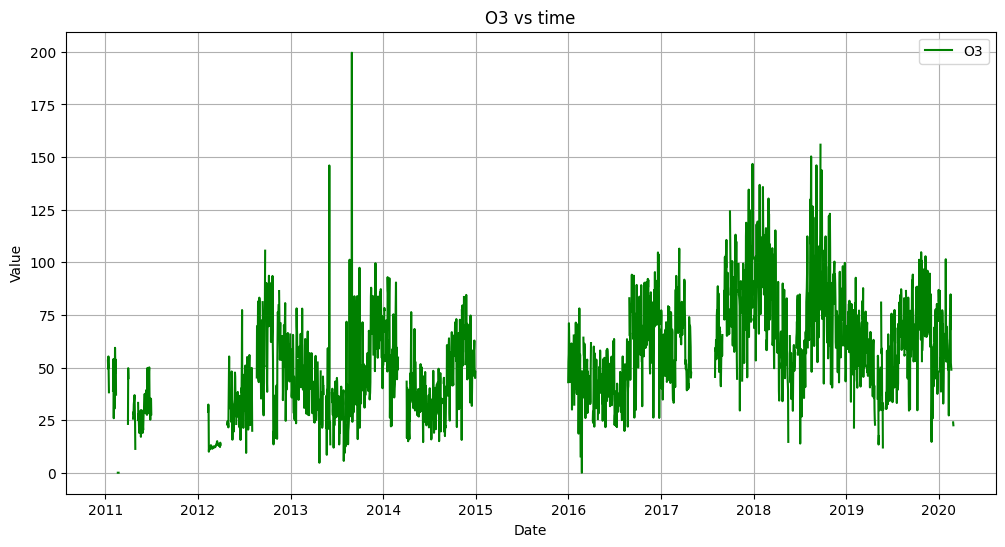

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
col = 'O3'
plt.plot(df_1.index, df_1[col], label=col, color = 'green')

plt.title("O3 vs time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# **Imputation of Missing Data**

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Load your dataset
df_test = df_final

# Select only numeric columns (IterativeImputer works best with numeric data)
numeric_df = df_test.select_dtypes(include='number')

# Initialize the imputer
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

# Fit and transform the data
imputed_array = imputer.fit_transform(numeric_df)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=numeric_df.columns)

# Replace original numeric columns with imputed ones
df_test[numeric_df.columns] = imputed_df

# Preview the result
print(df_test.head())

        Date        SO2       NO2         O3       PM25       PM10
0 2011-01-01  13.997828  25.54752  55.631861  31.826846  46.181893
1 2011-01-02  13.997828  25.54752  55.631861  31.826846  46.181893
2 2011-01-03  13.997828  25.54752  55.631861  31.826846  46.181893
3 2011-01-04  13.997828  25.54752  55.631861  31.826846  46.181893
4 2011-01-05  13.997828  25.54752  55.631861  31.826846  46.181893


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3345 entries, 0 to 3344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3345 non-null   datetime64[ns]
 1   SO2     3345 non-null   float64       
 2   NO2     3345 non-null   float64       
 3   O3      3345 non-null   float64       
 4   PM25    3345 non-null   float64       
 5   PM10    3345 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 156.9 KB


In [ ]:
df_2 = df_test.copy()
df_2['date'] = pd.to_datetime(df_2['Date'])
df_2 = df_2[['date','SO2', 'NO2', 'O3', 'PM25', 'PM10']]
df_2.set_index('date', inplace=True)

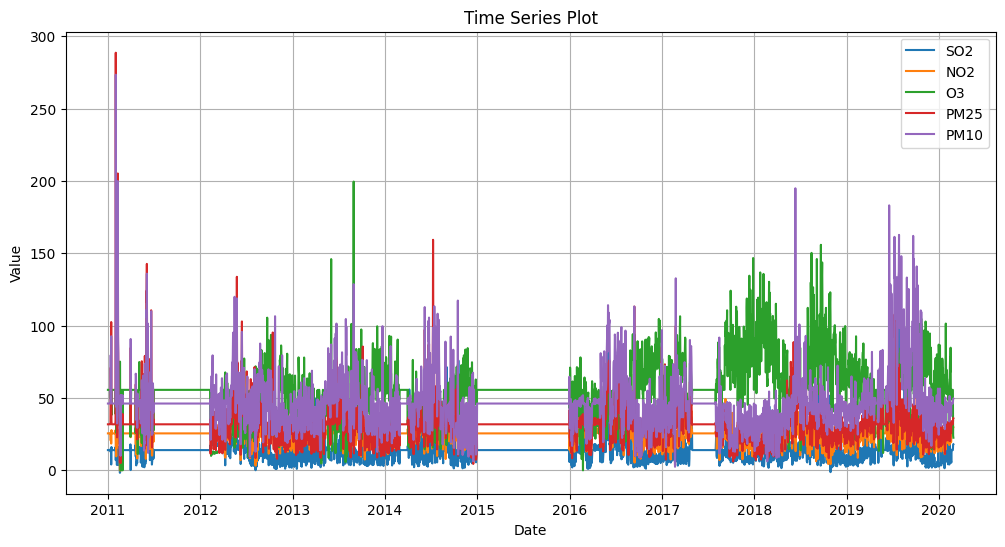

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
for col in df_2.columns:
    plt.plot(df_2.index, df_2[col], label=col)

plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()